# COGNITION visual characterization of spindle annotations

In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
#import kaleido

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath = os.environ['DATAPATH']
cognipath = datapath+'/COGNITION_v2'


## open MASS


In [2]:
signals, annotations, signalsMetadata = loadCOGNITIONSpindles_v2(cognipath,returnSignals=True)

In [3]:
signals

{'COG001': {'C3': array([ 6.25452392e+01, -1.26505051e+02,  5.42683629e+02, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'C4': array([ 1.57630682e+01, -4.07647014e+01,  2.68987858e+02, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'F3': array([ 7.52273438e+01, -1.47823422e+02,  5.88299024e+02, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'F4': array([-1.13177204e+01,  2.92804835e+00,  1.98758249e+02, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13])},
 'COG002': {'C3': array([ 9.60453530e+00, -4.10220285e+01,  1.15873381e+03, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'C4': array([ 3.80367071e+01, -7.67123381e+01,  7.78939126e+02, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'F3': array([ 6.93426482e+01, -1.38304205e+02,  1.35166617e+03, ...,
         -3.40867918e-13, -3.20542810e-13, -3.57858121e-13]),
  'F4': array([ 3.80388311e+01, -7.67170083e+01,

In [4]:
annotations=annotations[annotations.type=="spindle"].reset_index(drop=True)
annotations

,subjectId,channel,startTime,stopTime,duration,phase,type,samplerate,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,200,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,200,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,200,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,200,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,200,385728,385981
...,...,...,...,...,...,...,...,...,...,...
14684,COG009,C4,35328.677042,35329.338519,0.661477,3,spindle,200,7065735,7065868
14685,COG009,C4,35440.817120,35441.575876,0.758756,3,spindle,200,7088163,7088315
14686,COG009,C4,35521.498055,35522.373535,0.875480,3,spindle,200,7104300,7104475
14687,COG009,C4,39504.552529,39505.077815,0.525286,3,spindle,200,7900911,7901016


### visualise one spindle

In [5]:
subject='COG001'
channel='F4'
aux=signalsMetadata.loc[(signalsMetadata.subjectId==subject)&(signalsMetadata.channel==channel)]
signal=signals[subject][channel]
timepoints=np.arange(len(signal))/200
thisAnnotations=annotations.loc[annotations['subjectId']==subject].copy()

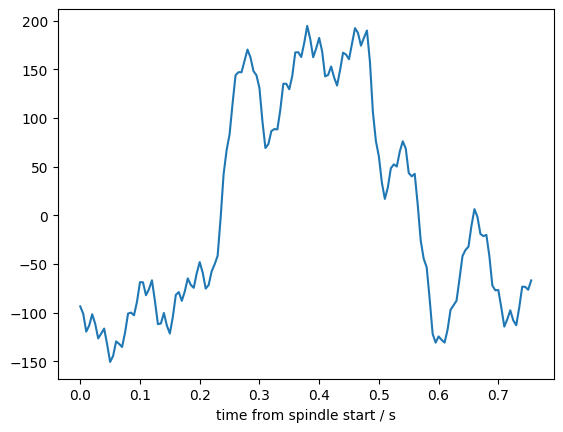

In [6]:
#just make a quick plot of the spindle with index i 
i=50

info=thisAnnotations.iloc[i]

plt.plot(timepoints[info.startInd:info.stopInd]-timepoints[info.startInd],signals[info.subjectId][info.channel][info.startInd:info.stopInd])
plt.xlabel("time from spindle start / s")
plt.show()


In [7]:
def getCharacteristicFreqsFromRow(row,signal,samplerate,freqRange,fftResolution=2048):
    signal=signal[row.subjectId][row.channel]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    return [peakFreq, medianFreq, power]

In [8]:
#define region of interest
freqRoi=[8,16]

In [9]:
thisAnnotations[['peakFreq','medianFreq','power']]=thisAnnotations.apply(lambda x: 
getCharacteristicFreqsFromRow(x,signals,200,freqRoi)
,axis=1, result_type ='expand')

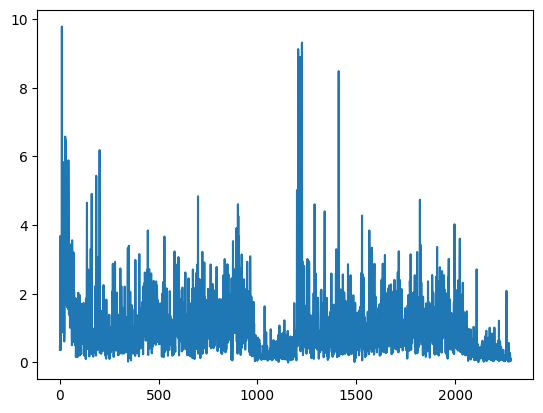

In [10]:
allpower=thisAnnotations.power
plt.plot(thisAnnotations.power/np.mean(thisAnnotations.power))
plt.show()

#we may have some outliers...

number of annotations not represented: 63


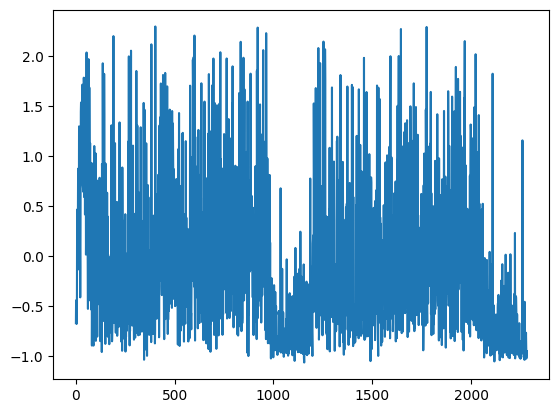

In [11]:
powerMean=np.mean(allpower)
powerStd=np.std(allpower)
allpowerZS=(allpower-powerMean)/powerStd
allpowerZS=allpowerZS[allpowerZS<2.33]
plt.plot(allpowerZS)
print("number of annotations not represented: "+str(len(thisAnnotations)-np.sum(allpowerZS<2.33)))

In [12]:
annotations

,subjectId,channel,startTime,stopTime,duration,phase,type,samplerate,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,200,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,200,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,200,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,200,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,200,385728,385981
...,...,...,...,...,...,...,...,...,...,...
14684,COG009,C4,35328.677042,35329.338519,0.661477,3,spindle,200,7065735,7065868
14685,COG009,C4,35440.817120,35441.575876,0.758756,3,spindle,200,7088163,7088315
14686,COG009,C4,35521.498055,35522.373535,0.875480,3,spindle,200,7104300,7104475
14687,COG009,C4,39504.552529,39505.077815,0.525286,3,spindle,200,7900911,7901016


In [13]:
def saveSpindleFreqsGraphII(row,signals,freqRange,fftResolution=2048,folder="./characteristicFreqsImagesII"):
    if not os.path.isdir(folder):
        os.mkdir(folder)

    fig = sb.make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7],specs=[[{}],[{"secondary_y": True}]])

    signal=signals[row.subjectId][row.channel]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/200)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    #timepoints
    timepoints=np.arange(len(signal))/200

    #upper plot
    graphPoints=seconds2index(5,200)
    segmentPoints=row.stopInd-row.startInd
    auxStart=int(row.startInd-(graphPoints-segmentPoints)/2)
    auxStop=auxStart+graphPoints
    fig.add_trace(go.Scatter(x=timepoints[auxStart:auxStop]-timepoints[row.startInd], y=signal[auxStart:auxStop]),
                row=1, col=1)
    fig.data[-1].name = '5 seconds of signal'
    fig.add_vline(x=0,line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.add_vline(x=timepoints[row.stopInd]-timepoints[row.startInd],line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.update_xaxes(title_text="time from spindle start / s",
                row=1, col=1)

    #lower plot
    fig.add_trace(go.Line(x=freq[roi],y=PSDSegment),
                row=2, col=1,secondary_y=False)
    fig.data[-1].name = 'PSD'
    fig.update_yaxes(rangemode="nonnegative",
                row=2, col=1,secondary_y=False)
    fig.add_trace(go.Line(x=freq[roi],y=np.cumsum(PSDSegment), fill='tozeroy',fillcolor='rgba(180,0,0,0.2)', mode='lines' ,line=dict(dash='dot',color='rgba(180,0,0,0.2)')),
                row=2, col=1,secondary_y=True)
    fig.data[-1].name = 'cummulative sum'
    fig.add_vline(x=medianFreq,line=dict(dash='dot',color='green'),
                row=2, col=1)
    fig.add_vline(x=peakFreq,line=dict(dash='dash',color='yellow'),
                row=2, col=1)
    fig.add_hline(y=0.5,line=dict(dash='dot',color='rgba(30,30,30,0.6)'),
                row=2, col=1,secondary_y=True)

    fig.update_yaxes(title_text="<b>PSD</b>",
                row=2, col=1, secondary_y=False)
    fig.update_yaxes(title_text="cummulative sum",
                row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="<b>frequency / Hz<b>",
                row=2, col=1)

    plotly.io.write_image(fig,folder+"/"+row.subjectId+"_"+row.channel+"_"+str(row.name).zfill(4)+"_spindle_visual_test.png")

In [14]:
#uncomment and run if you don't have the images, check under in your project folder (should take less than 5 mins)
aux=annotations.apply(lambda x: 
    saveSpindleFreqsGraphII(x,signals,freqRoi,folder=cognipath+"/graphical/annotationPSD")
    ,axis=1)

del aux

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


